In [122]:
import os, random, time
import xgboost
import datetime
import pygam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score

In [2]:
y_inven = pd.read_csv('./data/Y_inven.csv')
for i in range(0, y_inven.shape[0]):
    if np.divmod(y_inven.iloc[i, 1], 10)[0] == 0:
        y_inven.iloc[i, 1] = 'W0'+str(y_inven.iloc[i, 1])
    else:
        y_inven.iloc[i, 1] = 'W'+str(y_inven.iloc[i, 1])

In [13]:
x_sales = pd.read_csv('./data/X_Sales.csv')
x_product = pd.read_csv('./data/X_Product.csv')
x_sales = x_sales.drop(columns=x_sales.columns[0])
x_post_col = [s for s in x_sales.columns.values if 'Post' in s]
x_sales = x_sales.drop(columns=x_post_col)
x_product = x_product.drop(columns=x_product.columns[0])

In [15]:
y_inven_train = y_inven[y_inven['YEAR']==2020]
y_inven_test = y_inven[y_inven['YEAR']==2021]
x_sales_train = x_sales[x_sales['YEAR']==2020]
x_sales_test = x_sales[x_sales['YEAR']==2021]
x_product_train = x_product[x_product['YEAR']== 2020]
x_product_test = x_product[x_product['YEAR']== 2021]
x_product_train = x_product_train.dropna()
x_sales_train = x_sales_train.dropna()

In [16]:
tmp_x_train = pd.merge(x_product_train, x_sales_train, how='left', on=['WW', 'YEAR'])
x_train = pd.merge(tmp_x_train, y_inven_train, how='left', on=['WW', 'YEAR'])

In [17]:
idx_rm = x_train[(x_train['WW'] == 'W26') | (x_train['WW'] == 'W29') | (x_train['WW'] == 'W30') | (x_train['WW'] == 'W31')].index
x_train = x_train.drop(idx_rm)
x_train = x_train.reset_index(drop=True)

In [18]:
w_term = []
for i in range(0, 8):    
    if i == 0 :
        w_term.append(1)
    else:
        w_term.append(0.99**i)    

In [19]:
product_col = [s for s in x_train.columns.values if 'Product' in s]
x_product = x_train[product_col].copy()
x_product = x_product.reset_index(drop=True)
product_x_col = [s for s in x_product.columns.values if 'Var' in s]
product_y_col = [s for s in x_product.columns.values if 'Var' not in s]

sales_col = [s for s in x_train.columns.values if 'Sales' in s]
x_sales = x_train[sales_col].copy()
x_sales = x_sales.reset_index(drop=True)
sales_x_col = [s for s in x_sales.columns.values if 'Var' in s]
sales_y_col = [s for s in x_sales.columns.values if 'Var' not in s]

In [41]:
x_train.head()

Product_Var1  Product_Var2  Product_Var3  Product_Var4  Product_Var5  \
0           683          1210          1100          1100          1000   
1          1200          1310          1320          1320          1320   
2          1021          1320          1320          1210          1210   
3          1556          1210          1210          1320          1320   
4          1100          1100          1100          1100          1100   

   Product_Var6  Product_Var7  Product_Var8  YEAR   WW  ...  Sales_Var_1  \
0          1000          1000          1000  2020  W22  ...       1092.0   
1          1000          1000          1000  2020  W23  ...       1092.0   
2          1210          1000          1000  2020  W24  ...       1260.0   
3          1320          1320          1000  2020  W25  ...       1596.0   
4          1100          1210          1320  2020  W32  ...       1407.0   

   Sales_Var_2  Sales_Var_3  Sales_Var_4  Sales_Var_5  Sales_Var_6  \
0       1176.0       1176.0       1260.0       1092.0       1260.0   
1       1008.0       1008.0       1008.0       1008.0       1104.0   
2       1260.0       1260.0       1344.0       1344.0       1260.0   
3       1260.0       1260.0       1260.0       1260.0       1176.0   
4       1071.0        903.0        903.0       1239.0       1176.0   

   Sales_Var_7  Sales_Var_8   Sales  INVENTORY_PACK_D  
0       1176.0       1176.0   840.0       3004.000000  
1       1020.0       1356.0   924.0       3153.333333  
2       1176.0       1260.0  1258.0       3055.833333  
3       1260.0       1188.0  1344.0       3020.428571  
4       1260.0       1260.0  1407.0       2449.000000  

[5 rows x 21 columns]

In [20]:
sales_set = np.multiply(x_sales[sales_x_col], np.tile([w_term], x_sales.shape[0]).reshape(x_sales.shape[0], -1)).copy()

#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#model_sales = gp(kernel=kernel)
#model_sales = LR()
model_sales=xgboost.XGBRegressor(n_estimators=50, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
model_sales.fit(sales_set, x_sales[sales_y_col])
sales_hat = model_sales.predict(sales_set)


x_sales_test= x_sales_test.sort_values(['WW']).reset_index(drop=True)
sales_test = x_sales_test[sales_x_col].copy()
sales_test = np.multiply(sales_test, np.tile([w_term], sales_test.shape[0]).reshape(sales_test.shape[0], -1))

fcst_sales = model_sales.predict(sales_test)

In [21]:
product_set = np.multiply(x_product[product_x_col], np.tile([w_term], x_sales.shape[0]).reshape(x_sales.shape[0], -1)).copy()

#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#model_sales = gp(kernel=kernel)
#model_sales = LR()
model_product=xgboost.XGBRegressor(n_estimators=50, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
model_product.fit(product_set, x_product[product_y_col])
product_hat = model_product.predict(product_set)

x_product_test= x_product_test.sort_values(['WW']).reset_index(drop=True)
product_test = x_product_test[product_x_col].copy()
product_test = np.multiply(product_test, np.tile([w_term], product_test.shape[0]).reshape(product_test.shape[0], -1))

fcst_product = model_product.predict(product_test)

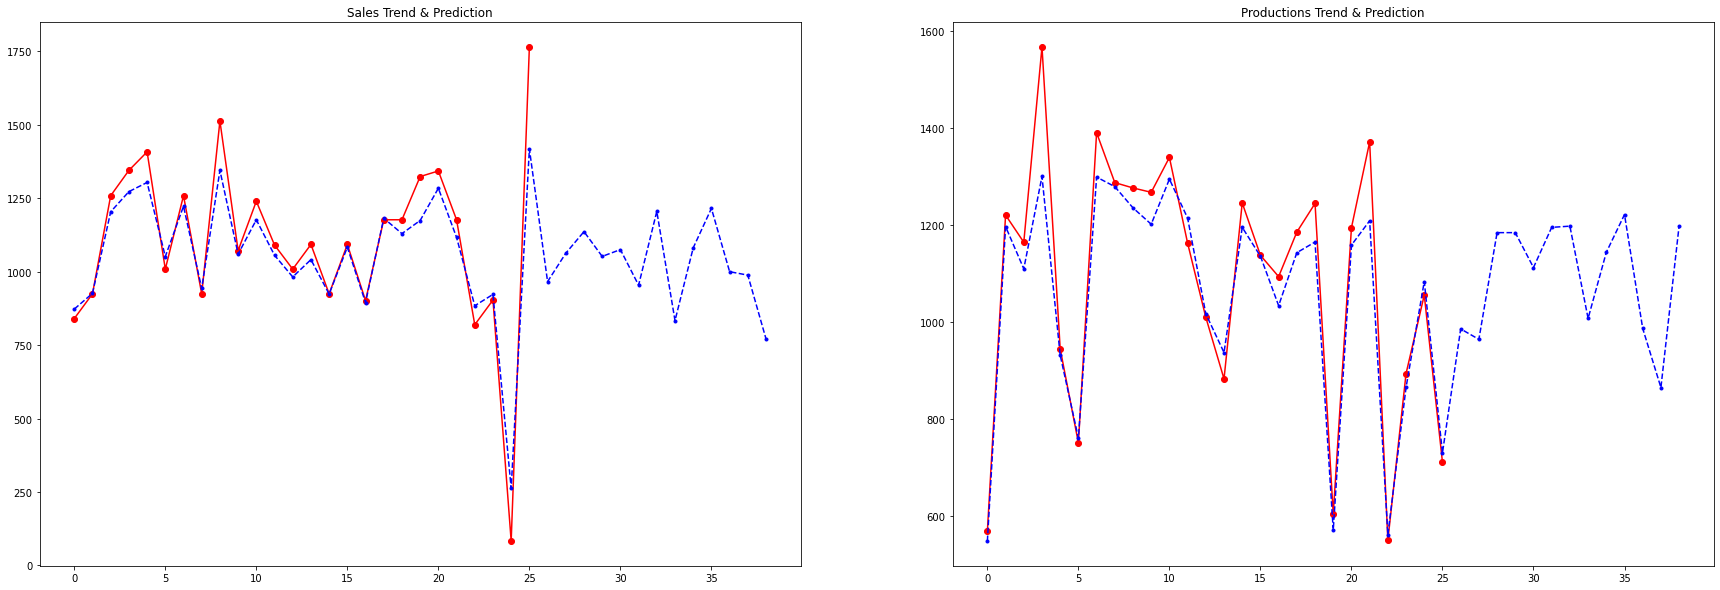

In [22]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.title("Sales Trend & Prediction")
plt.plot(x_sales[sales_y_col], color='red', marker='o')
plt.plot(np.append(sales_hat, fcst_sales), color='blue', linestyle='dashed', marker='.')
plt.subplot(1,2,2)
plt.title("Productions Trend & Prediction")
plt.plot(x_product[product_y_col], color='red', marker='o')
plt.plot(np.append(product_hat, fcst_product), color='blue', linestyle='dashed', marker='.')

In [23]:
ds = []
for i in range(0, x_train.shape[0]):
    tmp_ww =  str(x_train.iloc[i,np.where(x_train.columns == 'YEAR')[0][0]])+'-'+x_train.iloc[i,np.where(x_train.columns == 'WW')[0][0]]
    ds.append(datetime.datetime.strptime(tmp_ww+'-1', "%Y-W%W-%w"))
ds_test = []
for i in range(0, y_inven_test.shape[0]):
    tmp_ww_test =  str(y_inven_test.iloc[i,np.where(y_inven_test.columns == 'YEAR')[0][0]])+'-'+y_inven_test.iloc[i,np.where(y_inven_test.columns == 'WW')[0][0]]    
    ds_test.append(datetime.datetime.strptime(tmp_ww_test+'-1', "%Y-W%W-%w"))


In [77]:
inven_col = [s for s in x_train.columns.values if 'INVEN' in s]
y_train = x_train[['YEAR','WW']].iloc[2:].copy().reset_index(drop=True)
y_train['ds'] = ds[2:]
y_train['y'] = x_train[inven_col[0]].iloc[2:].copy().reset_index(drop=True)
y_train['Z_sale'] = x_train['Sales'].iloc[2:].reset_index(drop=True)#sales_hat
y_train['Z_product'] = x_train['Product'].iloc[:-2].reset_index(drop=True)#product_hat

In [78]:
y_test = y_inven_test[['YEAR','WW']]
y_test['ds'] = ds_test
y_test['y'] = y_inven_test[inven_col[0]]
y_test['Z_sale'] = fcst_sales[:9]
y_test['Z_product'] = np.append(x_train['Product'].iloc[-2:],  fcst_product[:7])

In [79]:
y_train.head()

YEAR   WW         ds            y  Z_sale  Z_product
0  2020  W24 2020-06-15  3055.833333  1258.0      569.0
1  2020  W25 2020-06-22  3020.428571  1344.0     1221.0
2  2020  W32 2020-08-10  2449.000000  1407.0     1165.0
3  2020  W33 2020-08-17  1889.714286  1008.0     1568.0
4  2020  W34 2020-08-24  1649.000000  1258.0      945.0

In [ ]:
model_time = Prophet(seasonality_mode='multiplicative', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True)
model_time.add_regressor('Z_sale', mode='additive')#, mode='multiplicative')
model_time.add_regressor('Z_product', mode='additive')#, mode='multiplicative')

model_time.fit(y_train)#[['ds','y','Z_sale','Z_product']])
fcst_inven_train = model_time.predict(y_train)
fcst_inven = model_time.predict(y_test)#['ds','y','Z_sale','Z_product'])

In [141]:
#train_X = pd.DataFrame(y_train[['Z_sale','Z_product']]); train_Y = np.array(y_train['y'])
#gam = pygam.LinearGAM(n_splines=10).gridsearch(train_X, train_Y)
#gam.summary()

fcst_model = xgboost.XGBRegressor(n_estimators=30, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=5)
fcst_model.fit(y_train[['Z_sale','Z_product']], y_train['y'])
fcst_predict_train = fcst_model.predict(y_train[['Z_sale','Z_product']])
fcst_predict = fcst_model.predict(y_test[['Z_sale','Z_product']])

In [143]:
fcst_predict_train

array([2219.987 , 2375.1511, 2383.884 , 1737.0702, 2004.2039, 1980.9918,
       1645.1959, 1807.8383, 1994.5618, 2132.4614, 1807.8383, 2047.6504,
       2007.6199, 2120.4397, 2182.8633, 2315.4705, 2315.4705, 2435.5574,
       2197.5247, 2144.7585, 2218.408 , 1838.068 , 2203.6306, 2165.305 ],
      dtype=float32)

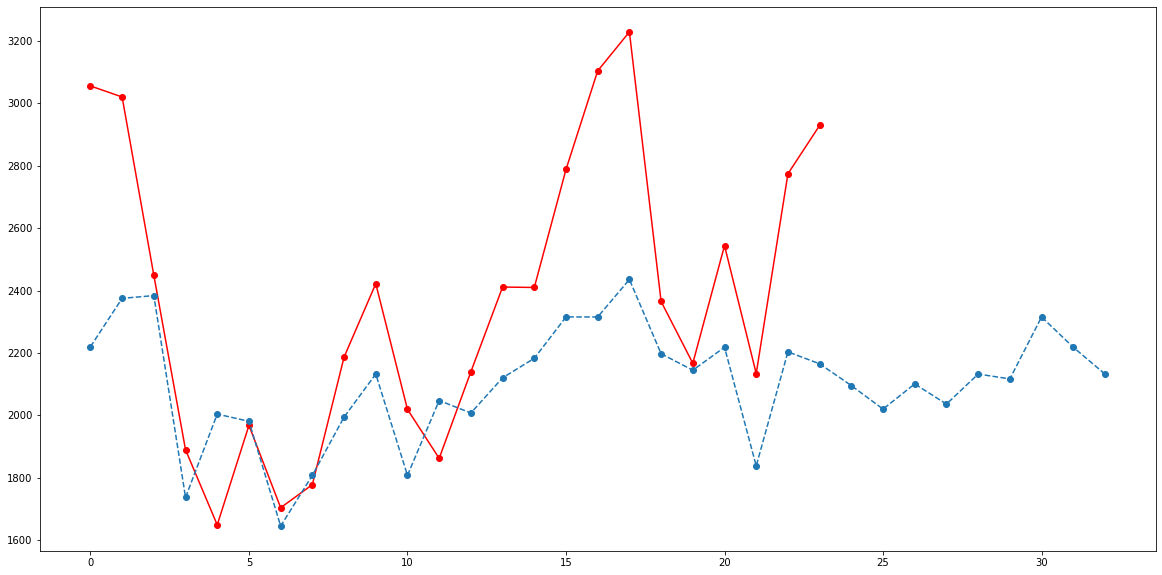

In [146]:
plt.figure(figsize=(20,10))
plt.plot(y_train['y'], color='red', marker='o')
plt.plot(np.append(fcst_predict_train, fcst_predict), marker='o', linestyle='dashed')

In [179]:
fcst_inven

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2021-01-04  47025.579967  2.869112e+03  2.973086e+03  47025.579967   
1 2021-01-11  48529.791234 -3.269436e+04 -3.259092e+04  48529.791233   
2 2021-01-18  50034.002501 -2.053445e+05 -2.052407e+05  50034.002499   
3 2021-01-25  51538.213768 -6.455178e+05 -6.454167e+05  51538.213764   
4 2021-02-01  53042.425034 -1.365881e+06 -1.365782e+06  53042.425028   
5 2021-02-08  54546.636301 -2.094492e+06 -2.094390e+06  54546.636292   
6 2021-02-15  56050.847568 -2.294761e+06 -2.294663e+06  56050.847556   
7 2021-02-22  57555.058835 -1.500770e+06 -1.500671e+06  57555.058819   
8 2021-03-01  59059.270102  2.015979e+05  2.017010e+05  59059.270083   

    trend_upper  Z_product  Z_product_lower  Z_product_upper    Z_sale  ...  \
0  47025.579967   0.000338         0.000338         0.000338  0.000163  ...   
1  48529.791234   0.000406         0.000406         0.000406  0.000013  ...   
2  50034.002503  -0.000532        -0.000532        -0.000532  0.000186  ...   
3  51538.213771  -0.000532        -0.000532        -0.000532 -0.000161  ...   
4  53042.425041  -0.000292        -0.000292        -0.000292  0.000013  ...   
5  54546.636310  -0.000651        -0.000651        -0.000651  0.000097  ...   
6  56050.847580  -0.000739        -0.000739        -0.000739  0.000184  ...   
7  57555.058850   0.000070         0.000070         0.000070  0.000302  ...   
8  59059.270120  -0.000568        -0.000568        -0.000568 -0.000120  ...   

     weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
0  0.543208      0.543208      0.543208  -1.481612     -1.481612   
1  0.543208      0.543208      0.543208  -2.216253     -2.216253   
2  0.543208      0.543208      0.543208  -5.645954     -5.645954   
3  0.543208      0.543208      0.543208 -14.066591    -14.066591   
4  0.543208      0.543208      0.543208 -27.292735    -27.292735   
5  0.543208      0.543208      0.543208 -39.939911    -39.939911   
6  0.543208      0.543208      0.543208 -42.482511    -42.482511   
7  0.543208      0.543208      0.543208 -27.618094    -27.618094   
8  0.543208      0.543208      0.543208   1.871846      1.871846   

   yearly_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     -1.481612             0.0                   0.0                   0.0   
1     -2.216253             0.0                   0.0                   0.0   
2     -5.645954             0.0                   0.0                   0.0   
3    -14.066591             0.0                   0.0                   0.0   
4    -27.292735             0.0                   0.0                   0.0   
5    -39.939911             0.0                   0.0                   0.0   
6    -42.482511             0.0                   0.0                   0.0   
7    -27.618094             0.0                   0.0                   0.0   
8      1.871846             0.0                   0.0                   0.0   

           yhat  
0  2.920113e+03  
1 -3.264239e+04  
2 -2.052941e+05  
3 -6.454685e+05  
4 -1.365832e+06  
5 -2.094441e+06  
6 -2.294714e+06  
7 -1.500720e+06  
8  2.016499e+05  

[9 rows x 28 columns]